In [25]:
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import random
import seaborn as sns
from helpers.evaluate_model import evaluate_model

### Getting Model Ready

In [2]:
#Load Data
with open('out/df_final.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,topic_label,type_of_material_Biography,type_of_material_Brief,type_of_material_Correction,type_of_material_Editorial,type_of_material_First Chapter,type_of_material_Interview,type_of_material_Letter,type_of_material_List,type_of_material_News,...,world,would,write,writer,writing,yankee,yankees,yearold,yet,young
0,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Politics,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159553,0.0
4,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [3]:
X = df.drop('topic_label', axis = 1)
y = df['topic_label']

In [4]:
#Best Performing Model
model = RandomForestClassifier(random_state = 42)


In [5]:
# train the model 
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Feature Importances Analysis

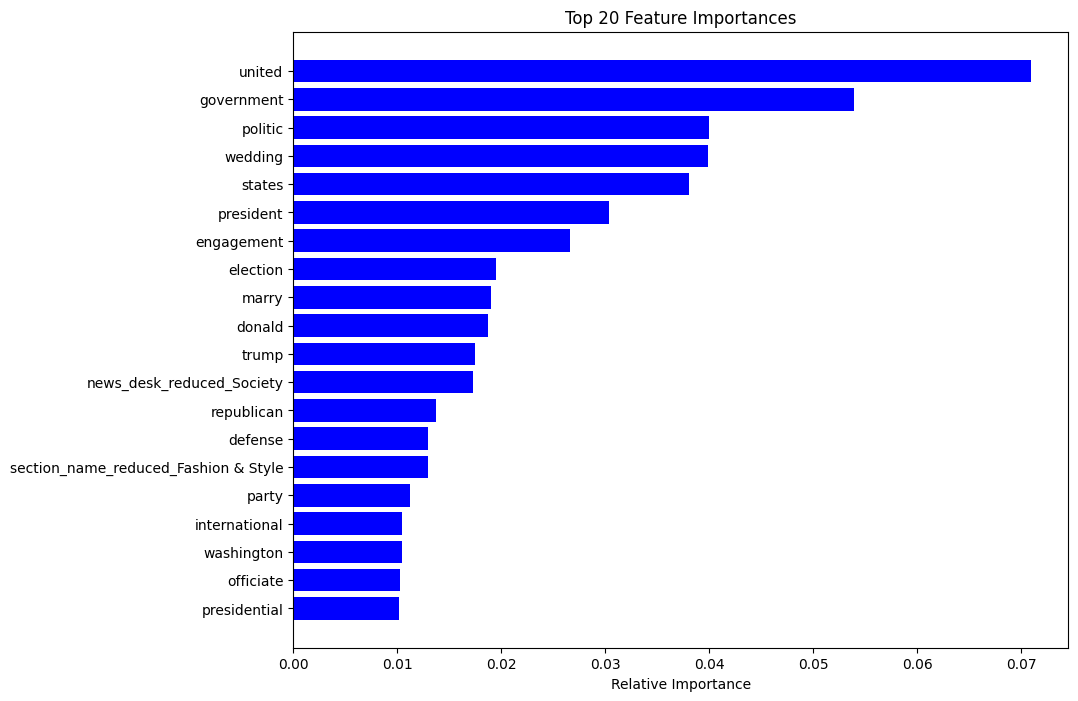

In [14]:
# get feature importances
importances = model.feature_importances_

# get top 10 features 
indices = np.argsort(importances)[-20:]

# get top 10 feature names
top_features = [X.columns[i] for i in indices]
top_importances = importances[indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), top_importances, color='b', align='center')
plt.yticks(range(len(indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()




For the feature importances analysis, we created a feature importance plot for the top 20 features from our best model. This plot shows the relative importance of each feature in our dataset after one-hot encoding and TF-IDF vectorization. It is evident that the predominant features are derived from the TF-IDF matrix, representing words from the "preprocessed_text" feature in our original dataset before vectorization. Additionally, we observed that two features not originating from the matrix are included. These supplementary predictors were chosen alongside the main "preprocessed_text" feature to potentially improve model performance. Indeed, the "preprocessed_text" — which we refer to as the main predictor — has played a pivotal role in the classification task. Additionally, the "other features," which we consider helper predictors, have also contributed to enhancing the model's classification capabilities.

## Ablation Analysis

### Removing all other features

In [7]:
df2 = pd.read_csv('processced text.csv')

In [8]:
df2.head()

,type_of_material,news_desk,section_name,author,preprocessed_text
0,News,Lifestyle & Leisure,Home & Garden,Penelope Green,point view prescriptive descriptive definite...
1,News,Lifestyle & Leisure,Home & Garden,Marianne Rohrlich,ten highend design gallery offer percent m...
2,News,Business,Business Day,Lauren Laughlin,banker may suffer decline dealmaking also take...
3,News,National,U.S.,Damien Cave,florida scale back purchase sugar company land...
4,News,Business,Technology,Bloomberg News,taketwo interactive maker grand theft auto acc...


In [9]:
df_filter = df2[["preprocessed_text"]]

In [10]:
#remove common words
#list of common words to remove
common_words_to_remove = ["new", "york", "year", "city"]

# define a function to remove those words from "preprocessed_text" feature
def remove_common_words(text, words_to_remove):
    tokens = text.split()  
    filtered_tokens = [token for token in tokens if token not in words_to_remove]
    return ' '.join(filtered_tokens)  

df_filter['preprocessed_text'] = df_filter['preprocessed_text'].apply(lambda text: remove_common_words(text, common_words_to_remove))

C:\Users\qfu88\AppData\Local\Temp\ipykernel_10648\1540151523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['preprocessed_text'] = df_filter['preprocessed_text'].apply(lambda text: remove_common_words(text, common_words_to_remove))


In [11]:
#vectorized the newly preprocessed data

tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

# apply it to preprocessed text
tfidf_matrix = tfidf_vect.fit_transform(df_filter['preprocessed_text'])

In [12]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vect.get_feature_names_out())


In [16]:
# Load the dominant_topic array
with open('out/dominant_topic_labels.pkl', 'rb') as f:
    dominant_topic = pickle.load(f)




In [17]:
## add topic label
# add topic label column
tfidf_df['topic_label'] = dominant_topic

topic_names = {0: 'Lifestyle', 1: 'Events', 2: 'Politics'}

tfidf_df['topic_label'] = tfidf_df['topic_label'].map(topic_names)


In [19]:
tfidf_df.head(1)

,abortion,abuse,accident,accord,accuse,across,act,action,actor,actress,...,would,write,writer,writing,yankee,yankees,yearold,yet,young,topic_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lifestyle


In [20]:
# train test split
features = tfidf_df.drop('topic_label', axis = 1)
label = tfidf_df['topic_label']

In [35]:
#Best Performing Model
model2 = RandomForestClassifier(random_state = 42)

### Evaluate the Model on Reduced featurs Data

In [36]:

mean_cv_score = cross_val_score(model2, features, label, cv = 5, scoring = 'roc_auc_ovr').mean()
print('Mean CV Score:', mean_cv_score)

Mean CV Score: 0.9891558309570868


### Drop top 20 features

In [46]:
# Features to drop 
features_to_drop = top_features[-20:]

# Drop the top 10 features from the DataFrame
df_dropped = df.drop(columns=features_to_drop)


In [42]:
# train test split
features2 = df_dropped.drop('topic_label', axis = 1)
label2 = df_dropped['topic_label']

In [43]:
#Best Performing Model
model3 = RandomForestClassifier(random_state = 42)

In [44]:
mean_cv_score = cross_val_score(model3, features2, label2, cv = 5, scoring = 'roc_auc_ovr').mean()
print('Mean CV Score:', mean_cv_score)

Mean CV Score: 0.9634481574686948


### Drop top 10 features from tfidf_df

In [48]:
# Features to drop 
features_to_drop = top_features[-10:]

# Drop the top 10 features from the DataFrame
tfidf_df_dropped = tfidf_df.drop(columns=features_to_drop)

In [49]:
# train test split
features3 = tfidf_df_dropped.drop('topic_label', axis = 1)
label3 = tfidf_df_dropped['topic_label']

In [51]:
#Best Performing Model
model4 = RandomForestClassifier(random_state = 42)

In [52]:
mean_cv_score = cross_val_score(model4, features3, label3, cv = 5, scoring = 'roc_auc_ovr').mean()
print('Mean CV Score:', mean_cv_score)

Mean CV Score: 0.9656786114014435
